Tutorial 4. Working with Generative Adversarial Networks on top of Neural Wrappers
==================================================

This is the fourth tutorial and it focuses on the implementation of the GANs, under `neural_wrappers.generative_adversarial_network`.

This isn't a comprehensive GAN tutorial, but rather a high level API introduction to the GAN implementation. The purpose is to generate MNIST digits in an usupervised learning fashion.

### 1. Definining the reader

Like in most tutorial, we'll use the MNIST dataset, which is assumed already converted (as covered in tutorial 2).

In [1]:
import numpy as np
from neural_wrappers.readers import MNISTReader
from neural_wrappers.utilities import getGenerators, toCategorical

reader = MNISTReader("/home/mihai/Public/Datasets/mnist/mnist.h5", 
    dimTransform = {
        "images" : lambda x : np.float32(x) / 255,
        "labels" : lambda x : toCategorical(x, numClasses=10)
    })
print(reader.summary())

generator, numSteps = getGenerators(reader, miniBatchSize=20, keys=["train"])
print("Train steps:", numSteps)

[MNIST Reader] Setup complete
[Dataset summary]
General dataset reader. Update __str__ in your dataset for more details when using summary.
All dims: {'images', 'labels'}. Data dims: ['images']. Label dims: ['labels']
Dim transforms: {'images': <function <lambda> at 0x7f5af413db80>, 'labels': <function <lambda> at 0x7f5aec75d8b0>}
Normalizers: {'images': 'identity', 'labels': 'identity'}

Train steps: 3000


#### 1.1 The GAN Reader

The GAN network require a special protocol for the generated data. Instead of generating (data, labels) pairs, we will generate the following data.

`(gNoise, gLabels), ((trueData, dNoise), dLabels) = items`

Basically, we'll have some noise data (used for generating fake data). This is divided in two parts (gNoise and dNoise) because the networks are trained alternatively, as said earlier. Also, we can have labels (if we'd like a custom generator criterion). If nothing is defined, this can be left as Nones. Finally, trueData represent the images.

**The API may change in future**

In [2]:
class GANReader(MNISTReader):
    def __init__(self, noiseSize, **kwargs):
        self.noiseSize = noiseSize
        super().__init__(**kwargs)

    def iterate_once(self, type, miniBatchSize):
        for data, labels in super().iterate_once(type, miniBatchSize):
            # We need to give items for the entire training epoch, which includes optimizing both the generator and
            #  the discriminator. We also don't need any labels for the generator, so we'll just pass None

            MB = data.shape[0]
            gNoise = np.random.randn(MB, self.noiseSize).astype(np.float32)
            dNoise = np.random.randn(MB, self.noiseSize).astype(np.float32)

            # Pack the data in two components, one for G and one for D
            yield (gNoise, None), ((data, dNoise), None)

reader = GANReader(noiseSize=100, datasetPath="/home/mihai/Public/Datasets/mnist/mnist.h5", 
    dimTransform = {
        "images" : lambda x : np.float32(x) / 255,
        "labels" : lambda x : toCategorical(x, numClasses=10)
    })
print(reader.summary())
generator, numSteps = getGenerators(reader, miniBatchSize=20, keys=["train"])
print("Train steps:", numSteps)

[MNIST Reader] Setup complete
[Dataset summary]
General dataset reader. Update __str__ in your dataset for more details when using summary.
All dims: {'images', 'labels'}. Data dims: ['images']. Label dims: ['labels']
Dim transforms: {'images': <function <lambda> at 0x7f5ad6bd94c0>, 'labels': <function <lambda> at 0x7f5ad6bd9310>}
Normalizers: {'images': 'identity', 'labels': 'identity'}

Train steps: 3000


#### 2. Defining the Generator and Discriminator models

The GAN works by having two competing Neural Networks that are trained to minimize two distinctive losses. The Generator must generate, starting from random noise, an image that resembles the original dataset. This fake image alongside a real image is sent to the Discriminator and it must classify which is real and which is fake.

This is generalized by having multiple images sent at once (real and fake) as well as having variable number of steps for each model (however 1 step each is stable enough to not get any of the models too strong causing the other one to never learn anything anymore).

The algorithm can be described as such:

`gData = Generator(gNoise)
L = LG(gData, gLabels) + LD(gData) (gradients only for G's weights)
OptimizeG(L)
dData = Generator(dNoise)
L = LD(dData) + LD(trueData) (gradients only for D's weights)
OptimizeD(L)
`

The loss function for the discrimator is BCE, with ones for real data and zeros for fake data.

In [3]:
import torch as tr
import torch.nn.functional as F
import torch.nn as nn
from neural_wrappers.pytorch import NeuralNetworkPyTorch

class Generator(NeuralNetworkPyTorch):
    def __init__(self, inputSize, outputSize):
        super().__init__()
        assert len(outputSize) == 3
        self.inputSize = inputSize
        self.outputSize = outputSize

        self.fc1 = nn.Linear(self.inputSize, 128)
        self.fc2 = nn.Linear(128, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 512)
        self.bn3 = nn.BatchNorm1d(512)
        self.fc4 = nn.Linear(512, 1024)
        self.bn4 = nn.BatchNorm1d(1024)
        self.fc5 = nn.Linear(1024, outputSize[0] * outputSize[1] * outputSize[2])

    def forward(self, x):
        y1 = F.leaky_relu(self.fc1(x))
        y2 = F.leaky_relu(self.bn2(self.fc2(y1)), negative_slope=0.2)
        y3 = F.leaky_relu(self.bn3(self.fc3(y2)), negative_slope=0.2)
        y4 = F.leaky_relu(self.bn4(self.fc4(y3)), negative_slope=0.2)
        y5 = tr.tanh(self.fc5(y4))
        y5 = y5.view(-1, *self.outputSize)
        return y5

class Discriminator(NeuralNetworkPyTorch):
    def __init__(self, inputSize):
        super().__init__()
        assert len(inputSize) == 3
        self.inputSize = inputSize
        self.fc1 = nn.Linear(inputSize[0] * inputSize[1] * inputSize[2], 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 1)

    def forward(self, x):
        x = x.view(-1, self.inputSize[0] * self.inputSize[1] * self.inputSize[2])
        y1 = F.leaky_relu(self.fc1(x), negative_slope=0.2)
        y2 = F.leaky_relu(self.fc2(y1), negative_slope=0.2)
        y3 = tr.sigmoid(self.fc3(y2))
        y3 = y3.view(y3.shape[0])
        return y3


#### 2.1 Wrapping the models inside a GAN model.

We'll wrap the two models inside a GAN model that implements the logic defined earlier.

In [4]:
import torch.optim as optim
from neural_wrappers.pytorch import GenerativeAdversarialNetwork, device
from neural_wrappers.callbacks import SaveModels, PlotMetrics

generatorModel = Generator(inputSize=100, outputSize=(28, 28, 1))
generatorModel.setOptimizer(optim.SGD, lr=0.01)
discriminatorModel = Discriminator(inputSize=(28, 28, 1))
discriminatorModel.setOptimizer(optim.SGD, lr=0.01)

# Define model
model = GenerativeAdversarialNetwork(generator=generatorModel, discriminator=discriminatorModel).to(device)


#### 3. Training the model

This is a standard training pipeline that looks identical to previous tutorials. Also, for each epoch, we'll print a few samples to see the model's improvement in time using a custom callback.

In [5]:
from neural_wrappers.callbacks import Callback
import matplotlib.pyplot as plt
%matplotlib inline

class PlotCallback(Callback):
    def __init__(self, latentSpaceSize):
        super().__init__("PlotCallback")
        self.latentSpaceSize = latentSpaceSize

    def onEpochEnd(self, **kwargs):
        GAN = kwargs["model"]

        # Generate 20 random gaussian inputs
        randomNoise = np.random.randn(20, self.latentSpaceSize).astype(np.float32)
        npRandomOutG = GAN.generator.npForward(randomNoise)[..., 0] / 2 + 0.5

        # Plot the inputs and discriminator's confidence in them
        items = [npRandomOutG[j] for j in range(len(npRandomOutG))]

        ax = plt.subplots(4, 5)[1]
        for i in range(4):
            for j in range(5):
                ax[i, j].imshow(npRandomOutG[i * 4 + j], cmap="gray")
        plt.show()

model.addCallbacks([SaveModels("last"), PlotMetrics(["Loss"]), PlotCallback(100)])
print(model.summary())

[GAN summary]
General neural network architecture. Update __str__ in your model for more details when using summary.
[Generator]
[Model summary]
General neural network architecture. Update __str__ in your model for more details when using summary.
Parameters count: 1510032. Trainable parameters: 1510032.
Hyperparameters:
Metrics:
	- Loss (min)
Callbacks: None
Optimizer: SGD. Learning rate: 0.01, Momentum: 0, Dampening: 0, Weight Decay: 0, Nesterov: False
Optimizer Scheduler: None
GPU: False

[Discriminator]
[Model summary]
General neural network architecture. Update __str__ in your model for more details when using summary.
Parameters count: 533505. Trainable parameters: 533505.
Hyperparameters:
Metrics:
	- Loss (min)
Callbacks: None
Optimizer: SGD. Learning rate: 0.01, Momentum: 0, Dampening: 0, Weight Decay: 0, Nesterov: False
Optimizer Scheduler: None
GPU: False



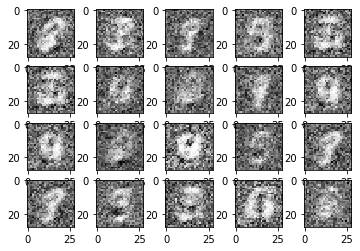

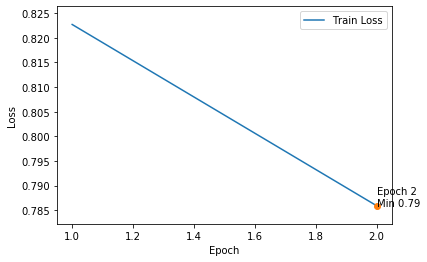

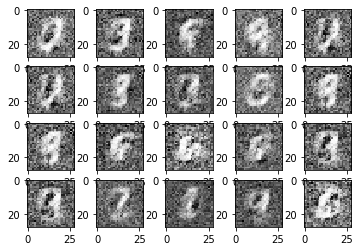

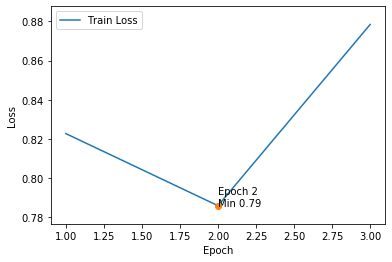

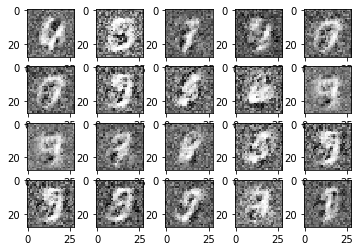

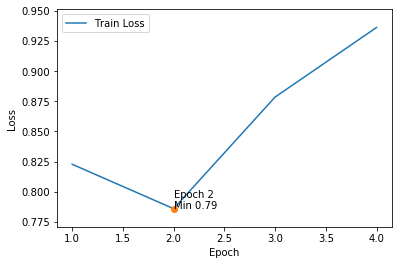

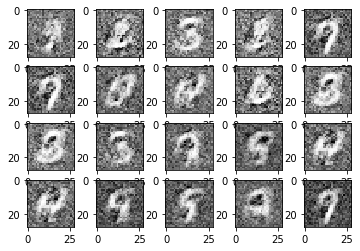

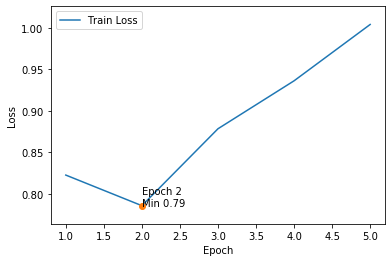

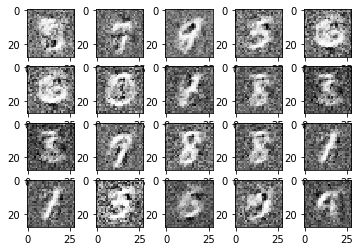

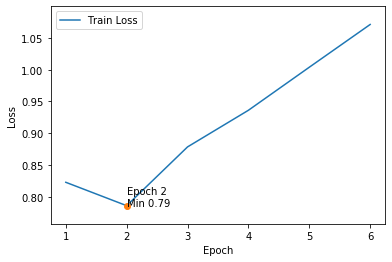

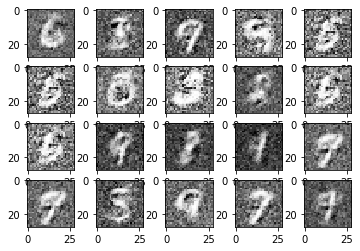

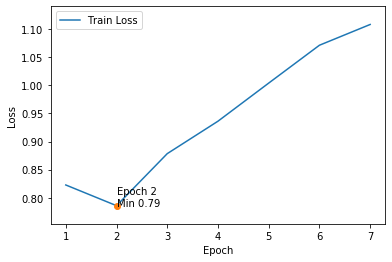

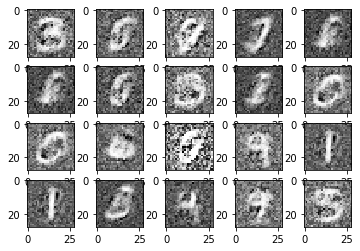

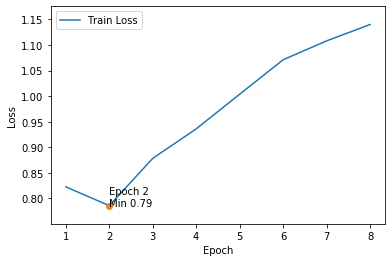

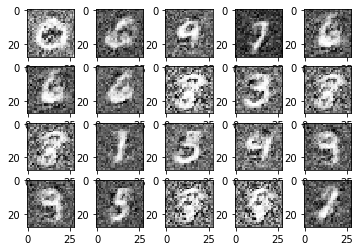

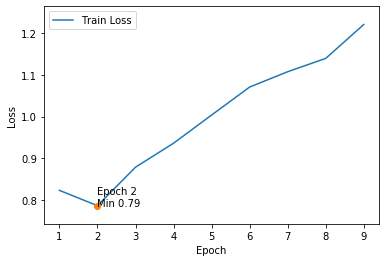

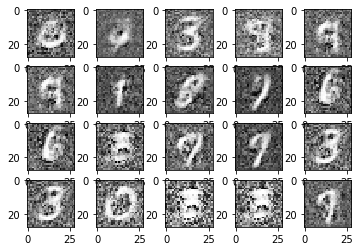

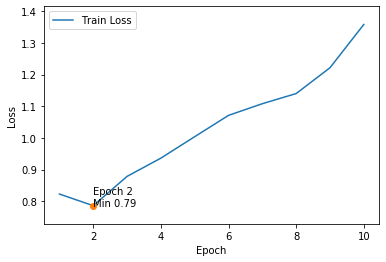

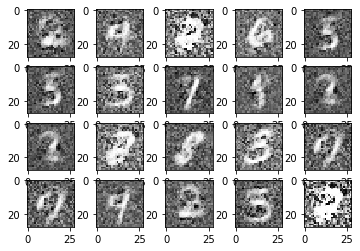

In [6]:
model.train_generator(generator, numSteps, numEpochs=10, printMessage="v1")

#### 4. Testing the model

We'll pick the latest stored model and generate some samples from random noise to see its quality as well as discriminator's response.

Loading model from model_last_Loss.pkl
Succesfully loaded weights (2043537 parameters) 
Succesfully loaded optimizer: SGD. Learning rate: 0.01, Momentum: 0, Dampening: 0, Weight Decay: 0, Nesterov: False
Succesfully loaded model history (epoch 10)
Succesfully loaded 4 callbacks (1 metrics)
Finished loading model


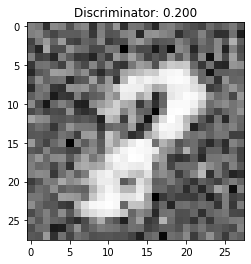

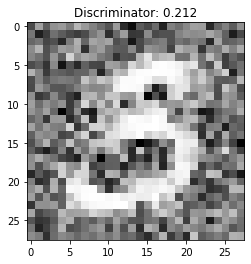

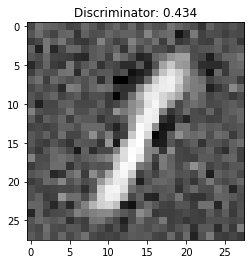

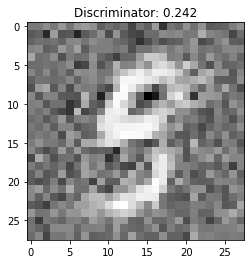

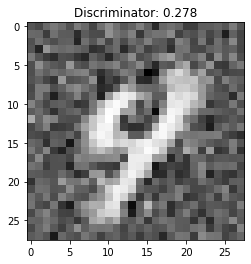

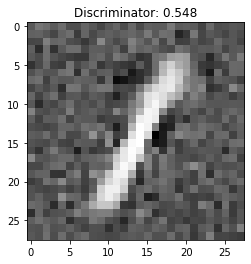

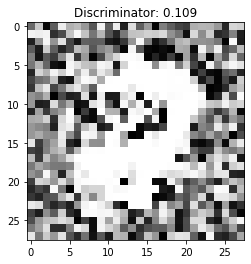

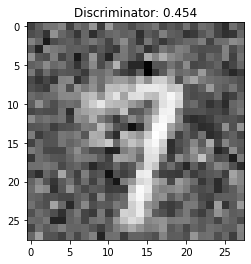

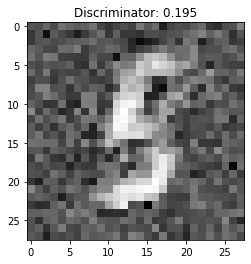

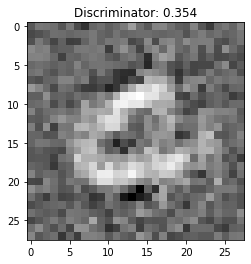

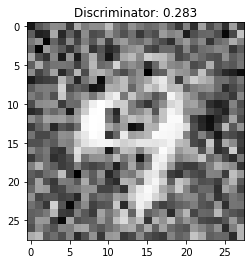

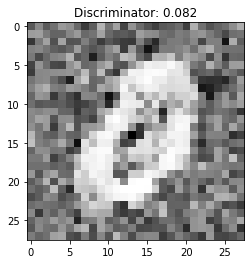

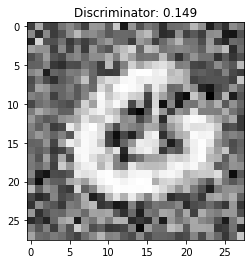

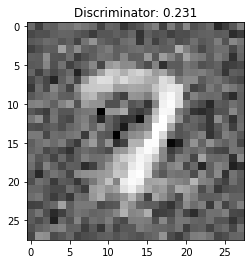

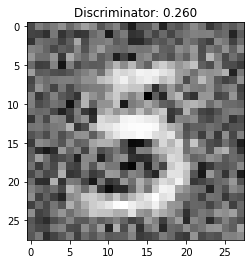

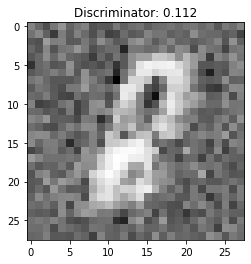

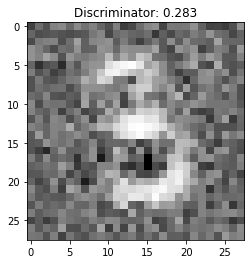

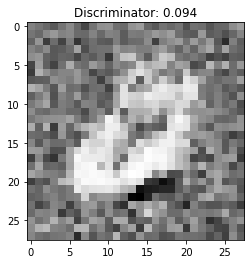

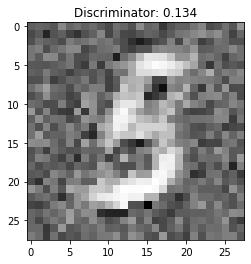

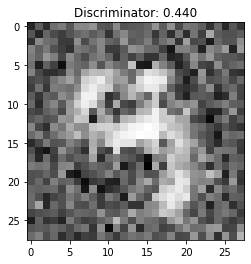

In [11]:
model.loadModel("model_last_Loss.pkl")

# Batches of 20, noise of 100 dims
randomInputsG = np.random.randn(20, 100).astype(np.float32)
randomOutG = model.generator.npForward(randomInputsG)
outD = model.discriminator.npForward(randomOutG)
randomOutG = randomOutG[..., 0]
for j in range(20):
    plt.imshow(randomOutG[j], cmap="gray")
    plt.title("Discriminator: %2.3f" % (outD[j]))
    plt.show()